In [1]:
# import library yang dibutuhkan
import pandas as pd
import duckdb as db
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# membuat fungsi untuk duckdb agar mempermudah eksekusi dari query
def query(sql_query):
    return db.sql(sql_query).df()

In [3]:
read_data = pd.read_csv('financial_data.csv')
pd.DataFrame(read_data)

,Date,Revenue,Expenses,Profit
0,2023-07-23,6779,9187,-2408
1,2023-11-11,15221,7708,7513
2,2023-12-07,8686,8693,-7
3,2023-05-01,5711,4666,1045
4,2023-01-18,6852,9987,-3135
...,...,...,...,...
995,2023-03-10,14458,9134,5324
996,2023-12-01,9571,3588,5983
997,2023-01-30,8672,8553,119
998,2023-03-03,15714,2261,13453


## 1. Calculate the aggregation value

In [4]:
# Menghitung aggregasi menggunakan method agg
aggr = read_data[['Revenue','Expenses','Profit']].agg(['mean','median','std','max','min'])
aggr.map(lambda x: round(x,2))

,Revenue,Expenses,Profit
mean,12311.36,5979.48,6331.88
median,12179.50,5965.00,6286.00
std,4363.00,2342.90,4969.54
max,19989.00,9999.00,17869.00
min,5023.00,2004.00,-4022.00


## 2. Monthly Trend in Revenue vs Profit

In [5]:
# Mengambil kolom yang dibutuhkan sekaligus merubah data type
# untuk kebutuhan analisis
sales_data = read_data[['Date','Revenue','Expenses','Profit']].copy()
sales_data['Date'] = pd.to_datetime(sales_data['Date'])

In [6]:
# membuat query yang sesuai untuk mendapatkan hasil yang diinginkan
monthly_sales = query(
    """
    SELECT
        DATE_TRUNC('month', Date) as Month,
        SUM(Revenue) as Total_Revenue,
        SUM(Profit) as Total_Profit,
        SUM(Expenses) as Total_Expenses
    FROM sales_data WHERE EXTRACT(YEAR from Date) == 2023
    GROUP BY 1
    ORDER BY 1
    """
)
monthly_sales

,Month,Total_Revenue,Total_Profit,Total_Expenses
0,2023-01-01,1296287.0,666442.0,629845.0
1,2023-02-01,971880.0,508637.0,463243.0
2,2023-03-01,1068769.0,569086.0,499683.0
3,2023-04-01,1011152.0,544902.0,466250.0
4,2023-05-01,952889.0,461561.0,491328.0
5,2023-06-01,735624.0,366990.0,368634.0
6,2023-07-01,1063433.0,535871.0,527562.0
7,2023-08-01,984361.0,504072.0,480289.0
8,2023-09-01,910322.0,464841.0,445481.0
9,2023-10-01,1085513.0,595927.0,489586.0


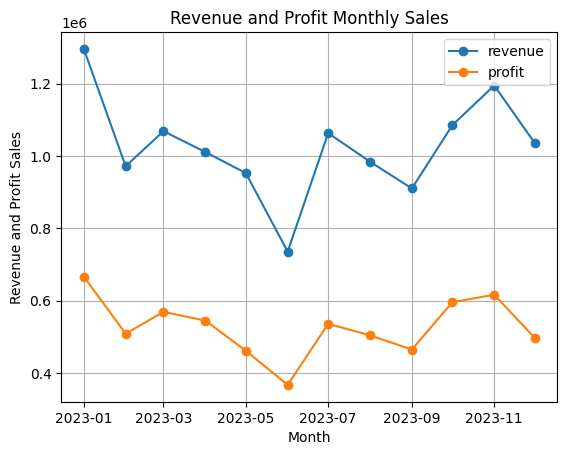

In [7]:
# Membuat grafik plot untuk melihat pola/trend dari data
plt.plot(monthly_sales['Month'], monthly_sales['Total_Revenue'], label='revenue', marker='o')
plt.plot(monthly_sales['Month'], monthly_sales['Total_Profit'], label= 'profit', marker='o')
plt.title('Revenue and Profit Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Revenue and Profit Sales')
plt.grid()
plt.legend()

Dari grafik tersebut dapat terlihat bahwa baik pendapatan maupun laba memiliki pola/trend yang cukup mirip. Perbedaan dari keduanya hanya nampak dari selisih dari data yang ada, sehingga membuat grafik dari laba berada di bawah mendekati 0 sedangkan grafik pendapatan berada di atas.

# 3. Monthly Profit Ratio based on Expenses

In [8]:
# membuat query untuk mengetahui rasio dari kedua data
ratio_data = query(
    """
    SELECT
        Month,
        ROUND(SUM((Total_Profit/Total_Expenses)*100),2) as ratio
    FROM monthly_sales
    GROUP BY 1
    ORDER BY 1
    """
)
ratio_data

,Month,ratio
0,2023-01-01,105.81
1,2023-02-01,109.80
2,2023-03-01,113.89
3,2023-04-01,116.87
4,2023-05-01,93.94
5,2023-06-01,99.55
6,2023-07-01,101.57
7,2023-08-01,104.95
8,2023-09-01,104.35
9,2023-10-01,121.72


## 4. Monthly Profit Ratio Visualization

Text(0, 0.5, 'Profit Rasio(%)')

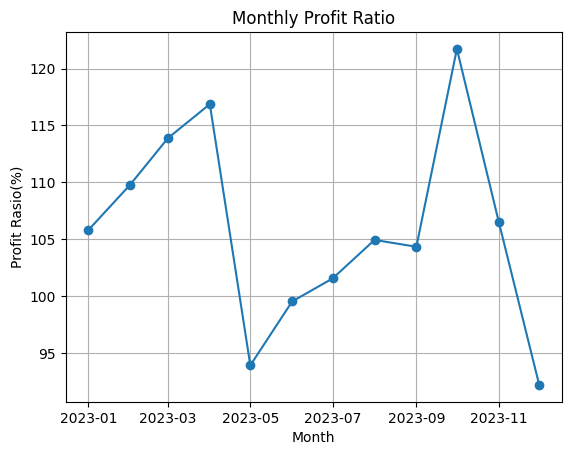

In [9]:
# membuat visualisasi grafik untuk profit rasio
plt.plot(ratio_data['Month'], ratio_data['ratio'], marker='o')
plt.grid(True)
plt.title("Monthly Profit Ratio")
plt.xlabel('Month')
plt.ylabel('Profit Rasio(%)')

## 5. Maximum and minimum Total Profit for each month

In [10]:
# mengurutkan data dari tertinggi ke rendah
monthly_sales[['Month','Total_Profit']].sort_values(by='Total_Profit', ascending=False)

,Month,Total_Profit
0,2023-01-01,666442.0
10,2023-11-01,616476.0
9,2023-10-01,595927.0
2,2023-03-01,569086.0
3,2023-04-01,544902.0
6,2023-07-01,535871.0
1,2023-02-01,508637.0
7,2023-08-01,504072.0
11,2023-12-01,497079.0
8,2023-09-01,464841.0


Berdasarkan output tersebut, dapat diketahui bahwa profit atau laba tertinggi yang diperoleh sebesar 666442 di bulan Januari sedangkan yang terendah berada pada bulan Juni dengan total laba bersih sebesar 366990.

## 6. Make a linear regression model including forecasting

In [11]:
# melihat korelasi antara total revenue dan expenses
df = pd.DataFrame(monthly_sales[['Total_Revenue','Total_Expenses']])
df.corr()

,Total_Revenue,Total_Expenses
Total_Revenue,1.000000,0.951587
Total_Expenses,0.951587,1.000000


Text(0.5, 1.0, 'Revenue vs Profit')

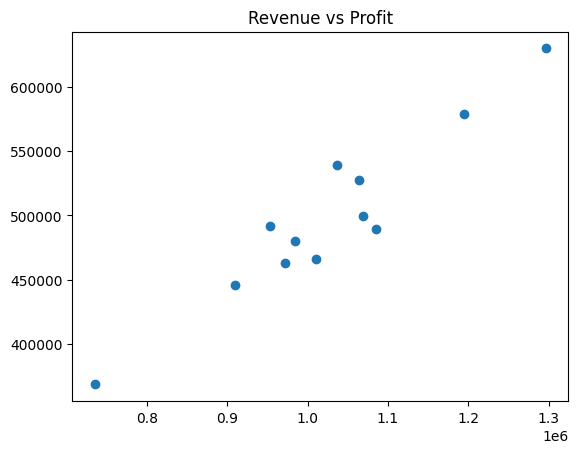

In [12]:
# melihat korelasi dengan scatter plot
plt.scatter(df['Total_Revenue'], df['Total_Expenses'])
plt.title("Revenue vs Profit")

Dari grafik scatter plot tersebut dapat diketahui bahwa korelasi antara keduanya sangat baik sehingga membentuk titik - titik yang linear. Dengan begitu, maka kedua variabel sudah sesuai untuk selanjutnya dilakukan analisis menggunakan regresi linear sederhana.

In [88]:
# import library yang dibutuhkan yaitu scikit learn untuk
# membuat model machine learning sederhana
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# ambil value data dan ubah ke dalam bentuk satu kolom
x = df['Total_Expenses'].values.reshape(-1,1)
y = df['Total_Revenue'].values.reshape(-1,1)

# split data menjadi data latih dan data uji
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# import model yang akan digunakan
lin_reg = LinearRegression()

# lakukan fitting pada data latih
lin_reg.fit(x_train, y_train)

# print koefisien dan intersept nya untuk mengetahui
# persamaan linear yang akan digunakan
print(lin_reg.coef_)
print(lin_reg.intercept_)

[[2.00354306]]
[25504.81291679]


In [89]:
# mencari nilai r square menggunakan score method dimana
# semakin mendekati 100 maka model yang digunakan semakin baik
lin_reg.score(x_test, y_test)

0.9856408530692412

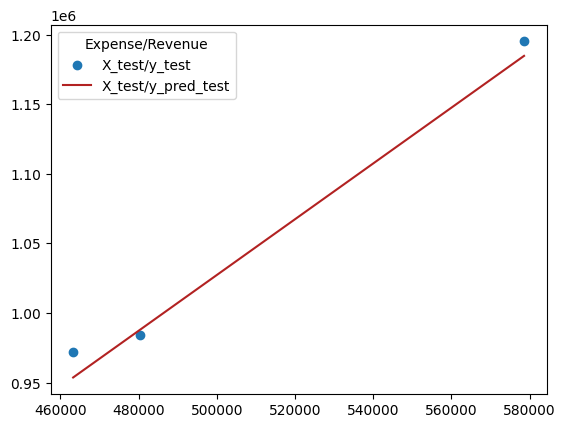

In [90]:
# lakukan prediksi berdasarkan pada data latih dan data uji
y_pred_test = lin_reg.predict(x_test)
y_pred_train = lin_reg.predict(x_train)

# membuat visualisasi untuk melihat hubungan antara data uji dan prediksi
plt.scatter(x_test, y_test)
plt.plot(x_test, y_pred_test, color='firebrick')
plt.legend(['X_test/y_test', 'X_test/y_pred_test'], title='Expense/Revenue')

Dari scatter plot tersebut, dapat diketahui bahwa nilai prediksi yang berupa garis berdekatan dengan titik - titik dari data uji. Hal ini menunjukkan bahwa data prediksi yang digunakan sudah cukup baik untuk dijadikan sebagai model dalam peramalan.

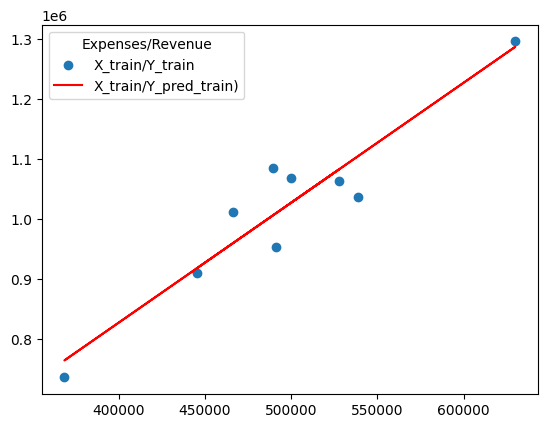

In [91]:
# membuat visualisasi untuk melihat hubungan antara data latih dan prediksi
plt.scatter(x_train, y_train)
plt.plot(x_train, y_pred_train, color='red')
plt.legend(['X_train/Y_train','X_train/Y_pred_train)'], title='Expenses/Revenue')

### Dari scatter plot tersebut, dapat diketahui bahwa nilai prediksi yang berupa garis berdekatan dengan titik - titik dari data latih. Hal ini menunjukkan bahwa data prediksi yang digunakan sudah cukup baik untuk dijadikan sebagai model dalam peramalan.

## 7. Make a revenue prediction based on the expenses new value

In [92]:
# membuat data biaya yang baru untuk mengetahui prediksi pendapatannya
# menggunakan model yang diperoleh pada regresi linear
new_data = pd.DataFrame({'Expenses': [486956, 512973, 433214, 666748, 532425, 426373,
                           444636, 698284, 673563, 462362, 572372, 423423]})
r = new_data['Expenses'].values.reshape(-1,1)
predict = pd.DataFrame(lin_reg.predict(r))
new_data['Revenue'] = round(predict,2)
new_data

,Expenses,Revenue
0,486956,1001142.12
1,512973,1053268.30
2,433214,893467.71
3,666748,1361363.14
4,532425,1092241.22
5,426373,879761.48
6,444636,916352.18
7,698284,1424546.87
8,673563,1375017.28
9,462362,951866.99


## 8. Calculate the coefficient correlation between total revenue and total profit 

In [93]:
correlation = pd.DataFrame(monthly_sales[['Total_Revenue','Total_Profit']])
corrcoef = correlation['Total_Revenue'].corr(correlation['Total_Profit'])
print("Koefisien korelasi antara biaya dan pendapatan adalah:", corrcoef)

Koefisien korelasi antara biaya dan pendapatan adalah: 0.9666034002389968


### 9. Terdapat hubungan yang terbilang kuat antara biaya dan pendapatan. Hal ini didasarkan pada nilai koefisien korelasi keduanya yang sebesar 0,96 atau mendekati 1, dimana semakin mendekati satu maka keterkaitan antar dua variabel akan semakin kuat. Sehingga dapat disimpulkan bahwa semakin tinggi biaya yang dikeluarkan maka akan mempengaruhi naiknya pendapatan dan begitu pula sebaliknya

## 10. Melihat adanya outlier dalam data biaya dan pendapatan menggunakan boxplot

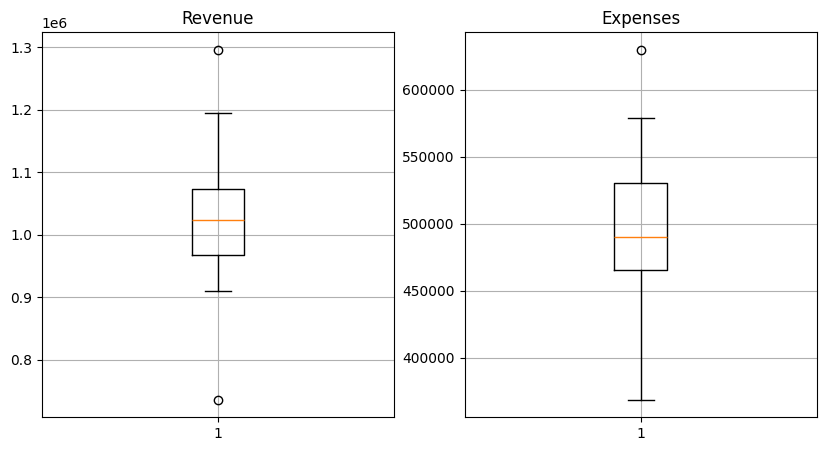

In [94]:
# membuat visualisasi menggunakan boxplot
plt.figure(figsize=(10,5))
expenses = plt.subplot(1,2,1)
expenses.boxplot(monthly_sales['Total_Revenue'])
plt.title('Revenue')
plt.grid(True)

revenue = plt.subplot(1,2,2)
revenue.boxplot(monthly_sales['Total_Expenses'])
plt.title('Expenses')
plt.grid(True)

In [96]:
round(monthly_sales['Total_Expenses'].describe(),2)

count        12.00
mean     498289.67
std       66449.95
min      368634.00
25%      465498.25
50%      490457.00
75%      530420.00
max      629845.00
Name: Total_Expenses, dtype: float64

In [95]:
# memastikan nilai dari outlier pada expenses boxplot
# menggunakan rumus Q1-1.5*(Q3-Q1) > x > Q1+1.5*(Q3-Q1)
465498.25 - 1.5 *(530420.00-465498.25), 530420.00 + 1.5 * (530420.00-465498.25)

(368115.625, 627802.625)

### Berdasarkan nilai tersebut, dapat diketahui bahwa nilai batas atas dari data expenses adalah 627802.625 sedangkan batas bawah nya sebesar 368115.625. Dengan begitu, nilai data yang berada di luar interval tersebut akan dianggap sebagai nilai outlier

In [97]:
round(monthly_sales['Total_Revenue'].describe(),2)

count         12.00
mean     1025946.67
std       140271.51
min       735624.00
25%       967132.25
50%      1023612.50
75%      1072955.00
max      1296287.00
Name: Total_Revenue, dtype: float64

In [98]:
# memastikan nilai dari outlier pada revenue boxplot
# menggunakan rumus Q1-1.5*(Q3-Q1) > x > Q1+1.5*(Q3-Q1)
967132.25 - 1.5 *(1072955.00-967132.25), 1072955.00 + 1.5 * (1072955.00-967132.25)

(808398.125, 1231689.125)

Berdasarkan nilai tersebut, dapat diketahui bahwa nilai batas atas dari data revenue adalah 808398.125 sedangkan batas bawah nya sebesar 1231689.125. Dengan begitu, nilai data yang berada di luar interval tersebut akan dianggap sebagai nilai outlier

## 11. Proyeksi keuangan pada tahun berikutnya berdasarkan trend dari data pada tahun 2023

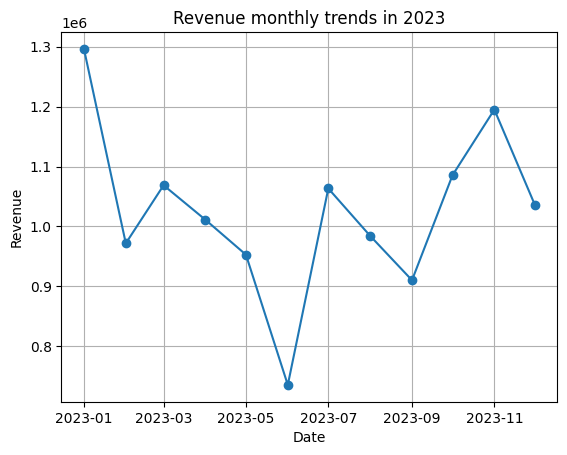

In [99]:
# melihat trend pada data historis sebelum melakukan proyeksi atau peramalan
financial_value = monthly_sales[['Month','Total_Revenue']].copy()

plt.plot(financial_value['Month'], financial_value['Total_Revenue'], marker='o')
plt.title('Revenue monthly trends in 2023')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)

Melihat trend tersebut, saya memutuskan untuk menggunakan model arima untuk melihat data peramalan di masa depan. Hal ini dikarenakan data trend terlihat cukup fluktuatif setiap bulannya dan salah satu model yang cukup akurat dalam membuat nilai peramalan dengan kondisi data seperti itu adalah model arima.

In [100]:
# STEP 1 = Identifikasi model dengan menggunakan uji ADF

# import library yang dibutuhkan
from statsmodels.tsa.stattools import adfuller

# Membuat fungsi untuk melakukan uji ADF
def adf_test(timeseries):
    print('Hasil Uji Augmented Dickey-Fuller (ADF):')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value',
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [101]:
# Nilai dari uji adf
adf_test(financial_value['Total_Revenue'])

Hasil Uji Augmented Dickey-Fuller (ADF):
Test Statistic                -1.310264
p-value                        0.624464
#Lags Used                     4.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64


### Dapat terlihat bahwa p-value dari data lebih besar dari nilai alpha (0,05) sehingga perlu dilakukan diferensiasi. Oleh karena itu, maka nilai yang dijadikan sebagai objek peramalan adalah nilai total revenue yang sudah di diferensiasikan.

In [102]:
# membuat kolom baru yang memuat nilai diferensiasi
financial_value['diff_1'] = financial_value['Total_Revenue'].diff().fillna(financial_value['Total_Revenue'])

# melakukan uji adf pada data yang sudah di diferensiasi
adf_test(financial_value['diff_1'])

Hasil Uji Augmented Dickey-Fuller (ADF):
Test Statistic                -7.490855e+00
p-value                        4.509698e-11
#Lags Used                     4.000000e+00
Number of Observations Used    7.000000e+00
Critical Value (1%)           -4.938690e+00
Critical Value (5%)           -3.477583e+00
Critical Value (10%)          -2.843868e+00
dtype: float64


### Dari hasil uji adf tersebut, dapat diketahui bahwa p-value sudah lebih kecil dari 0,05 sehingga nilai diferensiasi ini dapat digunakan sebagai data historis untuk selanjutnya dilakukan peramalan.

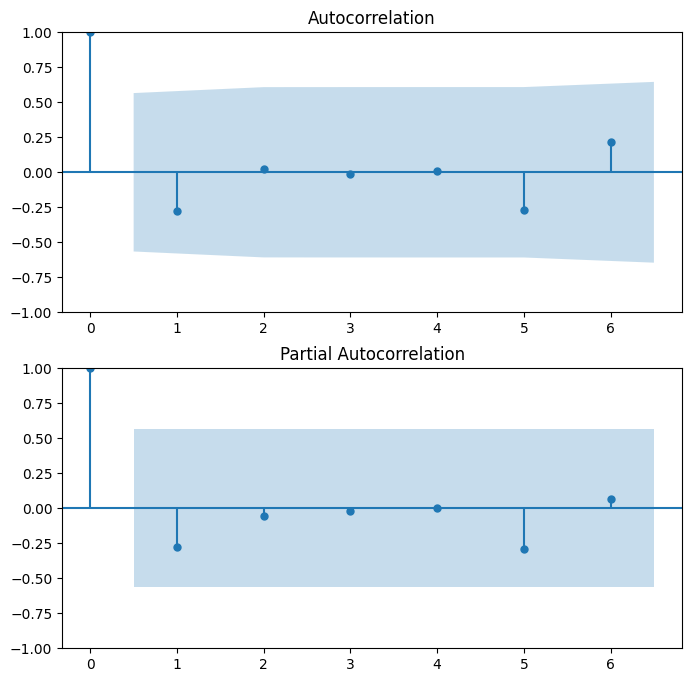

In [103]:
# STEP 2 = Mencari model arima yang sesuai dengan melihat plot acf dan pacf

# imort library yang dibutuhkan
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF dan PACF
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
plot_acf(financial_value['diff_1'], lags=6, ax=ax[0])
plot_pacf(financial_value['diff_1'], lags=6, ax=ax[1])
plt.show()

### Berdasarkan hasil dari plot acf dan pacf tersebut, kita dapat menentukan model Arima yang dapat digunakan. Titik yang menjauh dari garis 0 dapat kita pakai sebagai model arima (p,d,q) dimana p untuk nilai acf, d untuk diferensiasi, sedangkan q untuk nilai pacf. Karena ada cukup banyak model yang dapat digunakan, maka saya mencoba mencari model yang kira-kira paling sesuai dan akurat untuk dijadikan sebagai model peramalan.

In [104]:
# STEP 3 = Mencari nilai peramalan
from statsmodels.tsa.arima.model import ARIMA

# Buat dan latih model ARIMA
model = ARIMA(financial_value['diff_1'], order=(1,1,1))
results = model.fit()

# Print summary model
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 diff_1   No. Observations:                   12
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -155.826
Date:                Mon, 12 Aug 2024   AIC                            317.652
Time:                        08:20:38   BIC                            318.846
Sample:                             0   HQIC                           316.900
                                 - 12                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0993      0.279     -0.356      0.722      -0.646       0.448
ma.L1         -1.0000      0.639     -1.565      0.118      -2.253       0.253
sigma2      9.883e+10   6.47e-12   1.53e+22      0.0

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Setelah mencari satu per satu, saya memilih arima(0,5,1) sebagai model yang akan saya gunakan. Hal ini karena model arima yang baik adalah model yang memiliki nilai AIC dan BIC paling kecil diantara yang lainnya. Setelah saya mencari satu persatu, arima(0,1,5) merupakan model yang memiliki nilai AIC dan BIC paling kecil sehingga model ini paling sesuai untuk digunakan.

In [105]:
# membuat kolom baru untuk bulan-bulan dalam setahun peramalan
new_dates = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')

# membuat hasil peramalan dengan kurun waktu new_dates
forecast = results.forecast(steps=len(new_dates))

Karena nilai akhir peramalan diperoleh dari data historis yang sudah di diferensiasikan, maka ada beberapa nilai yang bertanda negatif sehingga tidak mungkin dijadikan sebagai data peramalan. Karena itulah kita lakukan invers pada nilai diferensiasi untuk mendapatkan nilai peramalan yang sebenarnya.

In [106]:
# Data asli
data_asli = financial_value['Total_Revenue'].values

# Data differensiasi
data_differensiasi = financial_value['diff_1'].values

# Nilai peramalan differensiasi
peramalan_differensiasi = forecast.values

# Fungsi untuk melakukan invers diferensiasi
def inverse_difference(history, forecast):
    return history + forecast

# Inversi diferensiasi untuk mendapatkan nilai peramalan sebenarnya
peramalan_asli = np.zeros_like(data_asli)
peramalan_asli[0] = data_asli[0]  # Nilai pertama sama dengan data asli
for i in range(1, len(data_asli)):
    peramalan_asli[i] = inverse_difference(peramalan_asli[i-1], peramalan_differensiasi[i-1])

# Menambahkan nilai peramalan ke data asli untuk mendapatkan peramalan yang sesungguhnya
peramalan_sesungguhnya = data_asli + peramalan_asli

Untuk membuat data menjadi lebih akurat, kita lakukan kembali penyesuaian pada nilai dari data yang ada karena data peramalan yang dihasilkan memiliki angka yang cukup besar. Oleh karena itu, kita menggunakan nilai rata-rata dari selisih data asli dan peramalan lalu dijumlahkan dengan data peramalan hingga diperoleh hasil akhir.

In [107]:
# Hitung selisih antara data asli dan hasil peramalan
selisih = data_asli - peramalan_sesungguhnya

# Hitung rata-rata dari selisih
rata_rata_selisih = np.mean(selisih)

# Tambahkan rata-rata selisih ke hasil peramalan
hasil_akhir = peramalan_sesungguhnya + rata_rata_selisih

print("Hasil Peramalan yang Disesuaikan:", hasil_akhir)

Hasil Peramalan yang Disesuaikan: [ 825488.92388536  606953.85131689  783407.84423369  807968.78529281
  831624.19409853  696303.38106244 1106054.00759916 1108923.88845146
 1116826.74404375 1373959.602145   1565445.45999705 1488403.31787385]


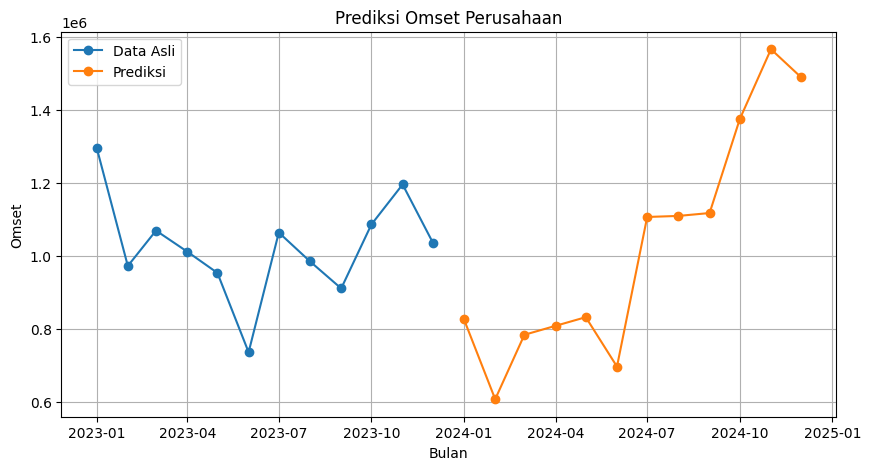

In [108]:
# Membuat plot untuk melihat hasil akhir sekaligus membandingkan data asli dan peramalan
plt.figure(figsize=(10,5))
plt.plot(financial_value['Month'], financial_value['Total_Revenue'], label='Data Asli', marker='o')
plt.plot(new_dates, hasil_akhir, label='Prediksi', marker='o')
plt.title('Prediksi Omset Perusahaan')
plt.xlabel('Bulan')
plt.ylabel('Omset')
plt.legend()
plt.grid(True)
plt.show()

## 12. Menghitung profit margin setiap bulan

In [109]:
# mengambil data yang diperlukan
margin = monthly_sales[['Month','Total_Profit','Total_Revenue']]

profit_margins = query(
    """
    SELECT
        Month,
        Total_Profit,
        Total_Revenue,
        ROUND(Total_Profit/Total_Revenue*100, 2) as profit_margin
    FROM margin
    GROUP BY 1,2,3
    ORDER BY 1 ASC
    """
)
profit_margins

,Month,Total_Profit,Total_Revenue,profit_margin
0,2023-01-01,666442.0,1296287.0,51.41
1,2023-02-01,508637.0,971880.0,52.34
2,2023-03-01,569086.0,1068769.0,53.25
3,2023-04-01,544902.0,1011152.0,53.89
4,2023-05-01,461561.0,952889.0,48.44
5,2023-06-01,366990.0,735624.0,49.89
6,2023-07-01,535871.0,1063433.0,50.39
7,2023-08-01,504072.0,984361.0,51.21
8,2023-09-01,464841.0,910322.0,51.06
9,2023-10-01,595927.0,1085513.0,54.90


## 13. Membandingkan profit margin setiap bulan untuk melihat profitabilitas

In [111]:
profit_grow = profit_margins[['Month','profit_margin']]
profit_grow_rate = query(
    """
    SELECT *,
        LAG(profit_margin, 1) OVER(ORDER BY Month) as previous_profit_margin,
        CASE
            WHEN previous_profit_margin is not null
            THEN ROUND((profit_margin-previous_profit_margin)/previous_profit_margin*100,2)
        ELSE NULL END AS profit_margin_growth 
    FROM profit_grow
    """
)
profit_grow_rate

,Month,profit_margin,previous_profit_margin,profit_margin_growth
0,2023-01-01,51.41,NaN,NaN
1,2023-02-01,52.34,51.41,1.81
2,2023-03-01,53.25,52.34,1.74
3,2023-04-01,53.89,53.25,1.20
4,2023-05-01,48.44,53.89,-10.11
5,2023-06-01,49.89,48.44,2.99
6,2023-07-01,50.39,49.89,1.00
7,2023-08-01,51.21,50.39,1.63
8,2023-09-01,51.06,51.21,-0.29
9,2023-10-01,54.90,51.06,7.52


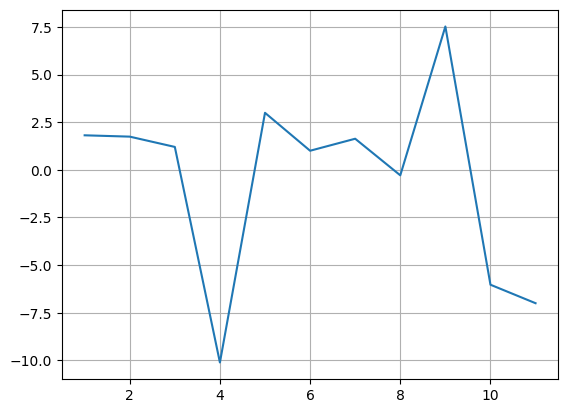

In [44]:
profit_grow_rate['profit_margin_growth'].plot()
plt.grid(True)

Berdasarkan tabel tersebut, dapat kita lihat bahwa pertumbuhan profit margin setiap bulannya mengalami fluktuasi yang cukup tinggi. Penurunan yang cukup signifikan terjadi pada bulan 5 sebesar 10%, diikuti dengan fluktuasi rendah pada 3 bulan berikutnya. Pada bulan 10, terjadi peningkatan yang cukup signifikan hingga hampir sebesar 8%, lalu diikuti dengan penurunan tajam pada sisa bulan berikutnya. Berdasarkan insight tersebut, dapat disimpulkan bahwa profitabilitas setiap bulannya di tahun 2023 itu terbilang sedang sehingga diperlukan peningkatan pendapatan di tahun berikutnya.